<a href="https://colab.research.google.com/github/b-fatma/S2I-DM/blob/master/src/6_unsupervised/kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
import time
from tqdm import tqdm

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading the data

In [5]:
y_train = pd.read_csv('/content/drive/MyDrive/dm_fire_prediction/feature_engineering/v1/y_train.csv')
y_test = pd.read_csv('/content/drive/MyDrive/dm_fire_prediction/feature_engineering/v1/y_test.csv')

X_test = pd.read_csv('/content/drive/MyDrive/dm_fire_prediction/feature_engineering/v1/X_test.csv')
X_train = pd.read_csv('/content/drive/MyDrive/dm_fire_prediction/feature_engineering/v1/X_train.csv')

X_test_scaled = pd.read_csv('/content/drive/MyDrive/dm_fire_prediction/feature_engineering/v1/X_test_scaled.csv')
X_train_scaled = pd.read_csv('/content/drive/MyDrive/dm_fire_prediction/feature_engineering/v1/X_train_scaled.csv')

In [6]:
# since we do not need separate train and test sets in unsupervised learning

X_scaled = pd.concat([X_train_scaled, X_test_scaled], axis=0)
y = pd.concat([y_train, y_test], axis=0)

In [7]:
X_scaled.columns

Index(['GRIDCODE', 'elevation', 'COARSE', 'SAND', 'CLAY', 'BULK', 'ORG_CARBON',
       'PH_WATER', 'TOTAL_N', 'CN_RATIO', 'CEC_SOIL', 'CEC_CLAY', 'CEC_EFF',
       'BSAT', 'ESP', 'TCARBON_EQ', 'GYPSUM', 'ELEC_COND', 'prec_autumn',
       'prec_spring', 'prec_summer', 'prec_winter', 'tmax_warm', 'tmin_warm',
       'tmax_cool', 'tmin_cool'],
      dtype='object')

# K-Means

## GridSearch

### w/ silhouette score scoring

In [8]:
param_grid = {
    'n_clusters': [2, 3, 4, 5, 6],
    'init': ['k-means++', 'random'],
    'n_init': [10],
    'max_iter': [300]
}



Silhouette score is computed on the same data used to fit, which is standard for clustering

In [9]:
best_score = -1
best_params = None
best_model = None

print("Grid Search Progress...")
total = len(param_grid['n_clusters']) * len(param_grid['init']) * len(param_grid['n_init']) * len(param_grid['max_iter'])
current = 0

for n_clusters in param_grid['n_clusters']:
    for init in param_grid['init']:
        for n_init in param_grid['n_init']:
            for max_iter in param_grid['max_iter']:
                current += 1

                kmeans = KMeans(
                    n_clusters=n_clusters,
                    init=init,
                    n_init=n_init,
                    max_iter=max_iter,
                    random_state=42
                )

                labels = kmeans.fit_predict(X_scaled)
                score = silhouette_score(X_scaled, labels)

                if score > best_score:
                    best_score = score
                    best_params = {
                        'n_clusters': n_clusters,
                        'init': init,
                        'n_init': n_init,
                        'max_iter': max_iter
                    }
                    best_model = kmeans

                print(f"\r{current}/{total} combinations tested", end='')

print("\n\nBest Parameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

print(f"\nBest Silhouette Score: {best_score:.4f}")

Grid Search Progress...
10/10 combinations tested

Best Parameters:
  n_clusters: 2
  init: k-means++
  n_init: 10
  max_iter: 300

Best Silhouette Score: 0.8560


=> Strong, well-separated clusters

### w/ ARI scoring

**But it makes more sense to optimize ARI**

In [10]:
param_grid = {
    'n_clusters': [2, 3, 4, 5, 6],
    'init': ['k-means++', 'random'],
    'n_init': [10, 20],
    'max_iter': [300, 500]
}


best_score = -1
best_params = None
best_model = None

print("Grid Search Progress...")
total = len(param_grid['n_clusters']) * len(param_grid['init']) * len(param_grid['n_init']) * len(param_grid['max_iter'])
current = 0

for n_clusters in param_grid['n_clusters']:
    for init in param_grid['init']:
        for n_init in param_grid['n_init']:
            for max_iter in param_grid['max_iter']:
                current += 1

                kmeans = KMeans(
                    n_clusters=n_clusters,
                    init=init,
                    n_init=n_init,
                    max_iter=max_iter,
                    random_state=42
                )

                labels = kmeans.fit_predict(X_scaled)
                score = adjusted_rand_score(y.squeeze(), labels)

                if score > best_score:
                    best_score = score
                    best_params = {
                        'n_clusters': n_clusters,
                        'init': init,
                        'n_init': n_init,
                        'max_iter': max_iter
                    }
                    best_model = kmeans

                print(f"\r{current}/{total} combinations tested", end='')

print("\n\nBest Parameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

print(f"\nBest ARI Score: {best_score:.4f}")

Grid Search Progress...
40/40 combinations tested

Best Parameters:
  n_clusters: 2
  init: k-means++
  n_init: 10
  max_iter: 300

Best ARI Score: 0.0142


In [11]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans
import pandas as pd

results = []

for k in [2, 3, 4, 5, 6]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    ari = adjusted_rand_score(y.squeeze(), labels)
    sil = silhouette_score(X_scaled, labels)
    db = davies_bouldin_score(X_scaled, labels)
    ch = calinski_harabasz_score(X_scaled, labels)

    results.append({
        'k': k,
        'ARI': ari,
        'Silhouette': sil,
        'Davies-Bouldin': db,
        'Calinski-Harabasz': ch
    })

df = pd.DataFrame(results)
print(df.to_string(index=False))

 k       ARI  Silhouette  Davies-Bouldin  Calinski-Harabasz
 2  0.014210    0.856050        0.235672      335758.202174
 3 -0.018896    0.776013        0.422251      453173.275318
 4 -0.017202    0.739226        0.677310      342388.494824
 5 -0.004039    0.647306        0.832173      271309.701643
 6 -0.028848    0.601485        0.796287      275615.322462


## Beyond GridSearch

#### Elbow method

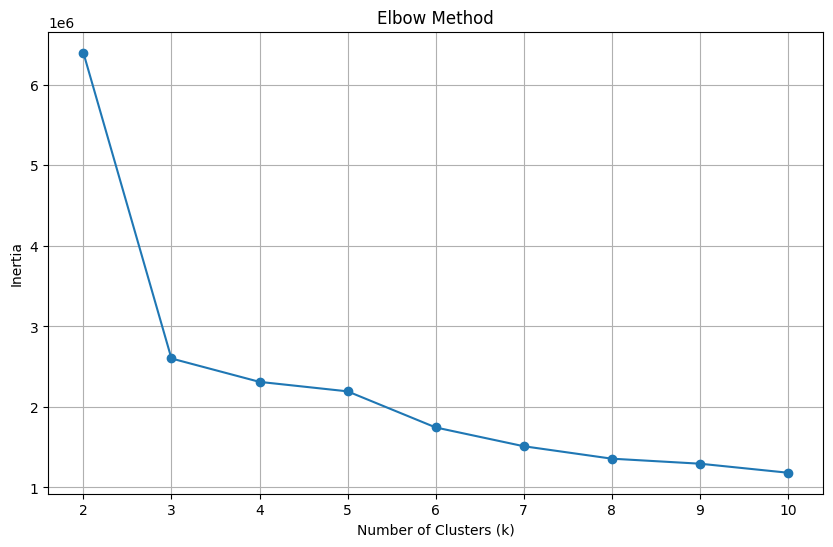

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid()
plt.show()

#### Distribution of fires per cluster

In [ ]:
best_model = KMeans(
                    n_clusters=6,
                    random_state=42
                )

labels = best_model.fit_predict(X_scaled)

In [ ]:
s_time = time.time()
y_pred = best_model.predict(X_scaled)
print(f"Prediction time: {time.time() - s_time:.4f}s")

Prediction time: 0.0248s


In [ ]:
print("\nClustering Metrics:")
print(f"  Silhouette Score: {silhouette_score(X_scaled, y_pred):.4f}")
print(f"  Davies-Bouldin Index: {davies_bouldin_score(X_scaled, y_pred):.4f}")
print(f"  Adjusted Rand Index: {adjusted_rand_score(y.squeeze(), y_pred):.4f}")


Clustering Metrics:
  Silhouette Score: 0.6015
  Davies-Bouldin Index: 0.7963
  Adjusted Rand Index: -0.0288


In [ ]:
print("\nCluster Distribution:")
unique, counts = np.unique(y_pred, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"  Cluster {cluster}: {count} samples ({count/len(y_pred)*100:.2f}%)")


Cluster Distribution:
  Cluster 0: 4561 samples (8.26%)
  Cluster 1: 40561 samples (73.45%)
  Cluster 2: 5228 samples (9.47%)
  Cluster 3: 1379 samples (2.50%)
  Cluster 4: 474 samples (0.86%)
  Cluster 5: 3016 samples (5.46%)


In [ ]:
print("\nFire Instances per Cluster:")
fire_pct = []
for cluster in unique:
    mask = y_pred == cluster
    n_fires = y.squeeze()[mask].sum()
    n_total = mask.sum()
    pct = (n_fires / n_total * 100) if n_total > 0 else 0
    fire_pct.append(pct)
    print(f"  Cluster {cluster}: {n_fires}/{n_total} fires ({pct}%)")


Fire Instances per Cluster:
  Cluster 0: 1060/4561 fires (23.24051743038807%)
  Cluster 1: 9995/40561 fires (24.641897389117627%)
  Cluster 2: 635/5228 fires (12.146136189747514%)
  Cluster 3: 550/1379 fires (39.88397389412618%)
  Cluster 4: 305/474 fires (64.34599156118144%)
  Cluster 5: 198/3016 fires (6.56498673740053%)


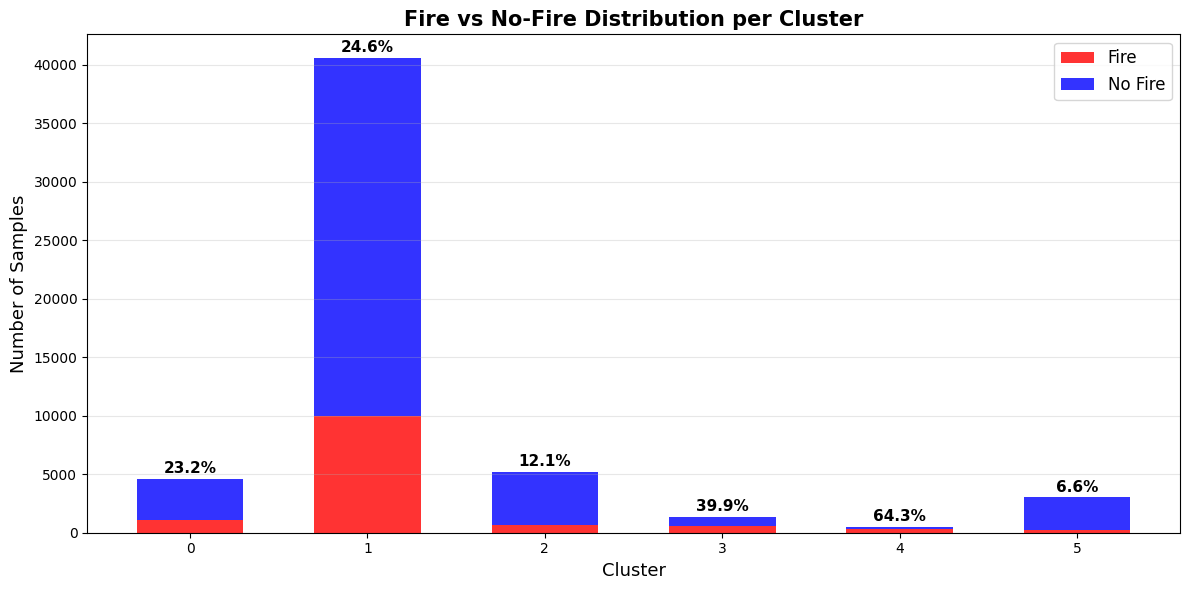

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

clusters = [0, 1, 2, 3, 4, 5]
fires = [1060, 9995, 635, 550, 305, 198]
no_fires = [3501, 30566, 4593, 829, 169, 2818]

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(clusters))
width = 0.6

p1 = ax.bar(x, fires, width, label='Fire', color='red', alpha=0.8)
p2 = ax.bar(x, no_fires, width, bottom=fires, label='No Fire', color='blue', alpha=0.8)

ax.set_xlabel('Cluster', fontsize=13)
ax.set_ylabel('Number of Samples', fontsize=13)
ax.set_title('Fire vs No-Fire Distribution per Cluster', fontsize=15, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(clusters)
ax.legend(fontsize=12)
ax.grid(alpha=0.3, axis='y')

for i, (f, nf) in enumerate(zip(fires, no_fires)):
    total = f + nf
    pct = f / total * 100
    ax.text(i, total + 500, f'{pct:.1f}%', ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

k=4 reveals meaningful subcategories:
   - High-risk fire zones (Cluster 3: 39.9% fires)
   - Low-risk zones (Cluster 2: 12.1% fires)  
   - Moderate-risk zones (Clusters 0,1: ~23% fires)
   

#### $Χ^2$ test

In [ ]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(y_pred, y.squeeze())
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square test:")
print(f"  χ² = {chi2:.2f}")
print(f"  p-value = {p_value:.6f}")
print(f"  {'Significant' if p_value < 0.05 else 'Not significant'} association")

Chi-square test:
  χ² = 1545.34
  p-value = 0.000000
  Significant association


=> Cluster membership is not random with respect to the labels

# From scratch

In [12]:
class KMeans_:
    def __init__(self, n_clusters=8, max_iters=100, tol=1e-4, random_state=42):
        """
        KMeans clustering implementation from scratch

        Parameters:
        -----------
        n_clusters : int, number of clusters
        max_iters : int, maximum number of iterations
        tol : float, tolerance for convergence
        random_state : int, random seed for reproducibility
        """
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.tol = tol
        self.random_state = random_state
        self.centroids = None
        self.labels_ = None
        self.inertia_ = None

    def _initialize_centroids(self, X):
        """Initialize centroids using random selection from data points"""
        np.random.seed(self.random_state)
        random_indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        return X[random_indices]

    def _compute_distances(self, X, centroids):
        """
        Compute euclidean distances between each point and centroids
        Vectorized for efficiency
        """
        # Shape: (n_samples, n_clusters)
        distances = np.sqrt(((X[:, np.newaxis] - centroids) ** 2).sum(axis=2))
        return distances

    def _assign_clusters(self, distances):
        """Assign each point to nearest centroid"""
        return np.argmin(distances, axis=1)

    def _update_centroids(self, X, labels):
        """Update centroids as mean of assigned points"""
        new_centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                new_centroids[k] = cluster_points.mean(axis=0)
            else:
                # If cluster is empty, reinitialize randomly
                new_centroids[k] = X[np.random.choice(X.shape[0])]
        return new_centroids

    def _compute_inertia(self, X, labels, centroids):
        """Compute sum of squared distances to nearest centroid"""
        inertia = 0
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                inertia += np.sum((cluster_points - centroids[k]) ** 2)
        return inertia

    def fit(self, X):
        """
        Fit KMeans to data

        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
        """
        # Initialize centroids
        self.centroids = self._initialize_centroids(X)

        print(f"Starting KMeans with {self.n_clusters} clusters...")
        print(f"Data shape: {X.shape}")

        for iteration in tqdm(range(self.max_iters), desc="KMeans iterations"):
            # Store old centroids to check convergence
            old_centroids = self.centroids.copy()

            # Assign clusters
            distances = self._compute_distances(X, self.centroids)
            self.labels_ = self._assign_clusters(distances)

            # Update centroids
            self.centroids = self._update_centroids(X, self.labels_)

            # Check convergence
            centroid_shift = np.sqrt(((self.centroids - old_centroids) ** 2).sum())

            if centroid_shift < self.tol:
                print(f"\nConverged at iteration {iteration + 1}")
                break

        # Compute final inertia
        self.inertia_ = self._compute_inertia(X, self.labels_, self.centroids)

        return self

    def predict(self, X):
        """Predict cluster labels for new data"""
        distances = self._compute_distances(X, self.centroids)
        return self._assign_clusters(distances)

    def fit_predict(self, X):
        """Fit and return cluster labels"""
        self.fit(X)
        return self.labels_

In [13]:
# the implmentation expects numpy arrays
X_scaled_np = X_scaled.to_numpy()
y_np = y.to_numpy()

In [14]:
kmeans = KMeans_(n_clusters=6, max_iters=100, random_state=42)

s_time = time.time()
kmeans.fit(X_scaled_np)
print(f"Training time: {time.time() - s_time:.2f}s")

s_time = time.time()
y_pred = kmeans.predict(X_scaled_np)
print(f"Prediction time: {time.time() - s_time:.2f}s\n")

Starting KMeans with 6 clusters...
Data shape: (55219, 26)


KMeans iterations:   8%|▊         | 8/100 [00:00<00:05, 16.69it/s]



Converged at iteration 9
Training time: 0.51s
Prediction time: 0.05s



In [15]:
ari = adjusted_rand_score(y.squeeze(), y_pred)
sil = silhouette_score(X_scaled, y_pred)
db = davies_bouldin_score(X_scaled, y_pred)


print("\nClustering Metrics:")
print(f"  Silhouette Score: {sil:.4f}")
print(f"  Davies-Bouldin Index: {db:.4f}")
print(f"  Adjusted Rand Index: {ari:.4f}")



Clustering Metrics:
  Silhouette Score: 0.3930
  Davies-Bouldin Index: 0.9490
  Adjusted Rand Index: -0.0244


In [16]:
kmeans = KMeans(n_clusters=6, random_state=42)

s_time = time.time()
kmeans.fit(X_scaled_np)
print(f"Training time: {time.time() - s_time:.2f}s")

s_time = time.time()
y_pred = kmeans.predict(X_scaled_np)
print(f"Prediction time: {time.time() - s_time:.2f}s\n")

Training time: 0.11s
Prediction time: 0.01s



In [17]:
ari = adjusted_rand_score(y.squeeze(), y_pred)
sil = silhouette_score(X_scaled, y_pred)
db = davies_bouldin_score(X_scaled, y_pred)


print("\nClustering Metrics:")
print(f"  Silhouette Score: {sil:.4f}")
print(f"  Davies-Bouldin Index: {db:.4f}")
print(f"  Adjusted Rand Index: {ari:.4f}")


Clustering Metrics:
  Silhouette Score: 0.6015
  Davies-Bouldin Index: 0.7963
  Adjusted Rand Index: -0.0288


# Analysis

## Basic 2D PCA Plot

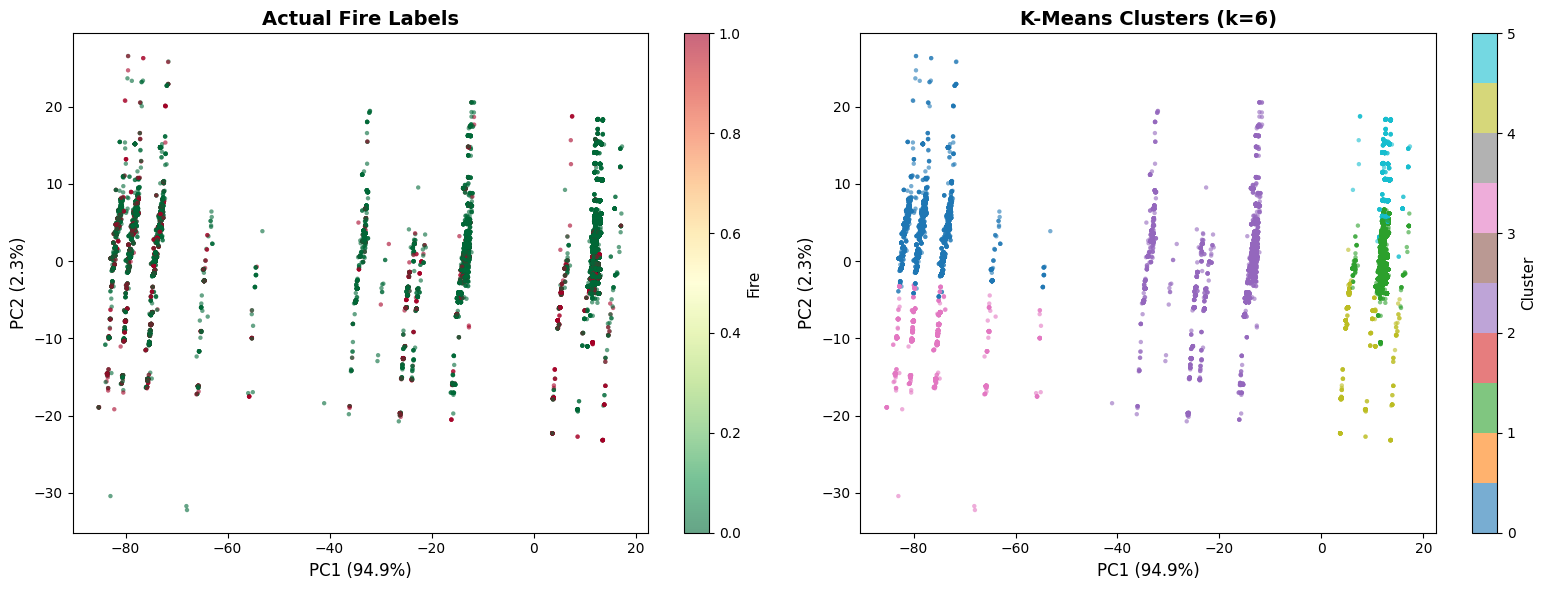

Total variance explained: 97.2%


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled.values)

# Convert y to numpy array
y_array = y.values if hasattr(y, 'values') else np.array(y)
y_pred_array = np.array(y_pred)

clusters = [0, 1, 2, 3, 4, 5]
colors = ['orange', 'orange', 'lightblue', 'red', 'darkred', 'green']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Actual labels
scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=y_array, cmap='RdYlGn_r',
                       alpha=0.6, s=10, edgecolors='none')
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
ax1.set_title('Actual Fire Labels', fontsize=14, fontweight='bold')
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('Fire', fontsize=11)

# Plot 2: Predicted clusters
scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_array, cmap='tab10',
                       alpha=0.6, s=10, edgecolors='none')
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
ax2.set_title('K-Means Clusters (k=6)', fontsize=14, fontweight='bold')
cbar2 = plt.colorbar(scatter2, ax=ax2, ticks=clusters)
cbar2.set_label('Cluster', fontsize=11)

plt.tight_layout()
plt.show()

print(f"Total variance explained: {pca.explained_variance_ratio_.sum()*100:.1f}%")

## Enhanced PCA with Cluster Centroids

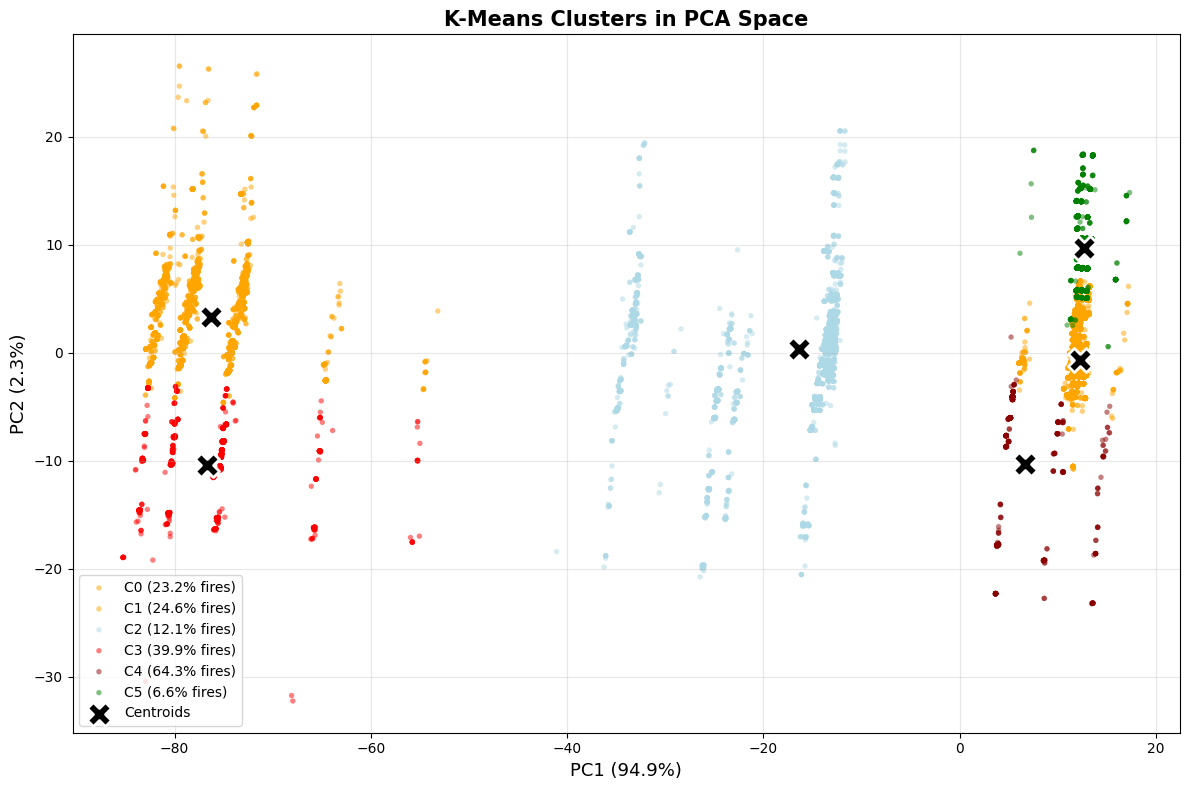

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled.values)

# Transform centroids to PCA space
centroids_pca = pca.transform(kmeans.cluster_centers_)

colors = ['orange', 'orange', 'lightblue', 'red', 'darkred', 'green']
fig, ax = plt.subplots(figsize=(12, 8))

# Plot points colored by cluster
for i, (color, pct) in enumerate(zip(colors, fire_pct)):
    mask = y_pred == i
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1],
               c=color, label=f'C{i} ({pct:.1f}% fires)',
               alpha=0.5, s=15, edgecolors='none')

# Plot centroids
ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
           c='black', marker='X', s=300, edgecolors='white',
           linewidths=2, label='Centroids', zorder=10)

# Annotate centroids
for i, (x, yy) in enumerate(centroids_pca):
    ax.annotate(f'C{i}', (x, yy), fontsize=12, fontweight='bold',
                ha='center', va='center', color='white')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=13)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=13)
ax.set_title('K-Means Clusters in PCA Space', fontsize=15, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 3D PCA plot

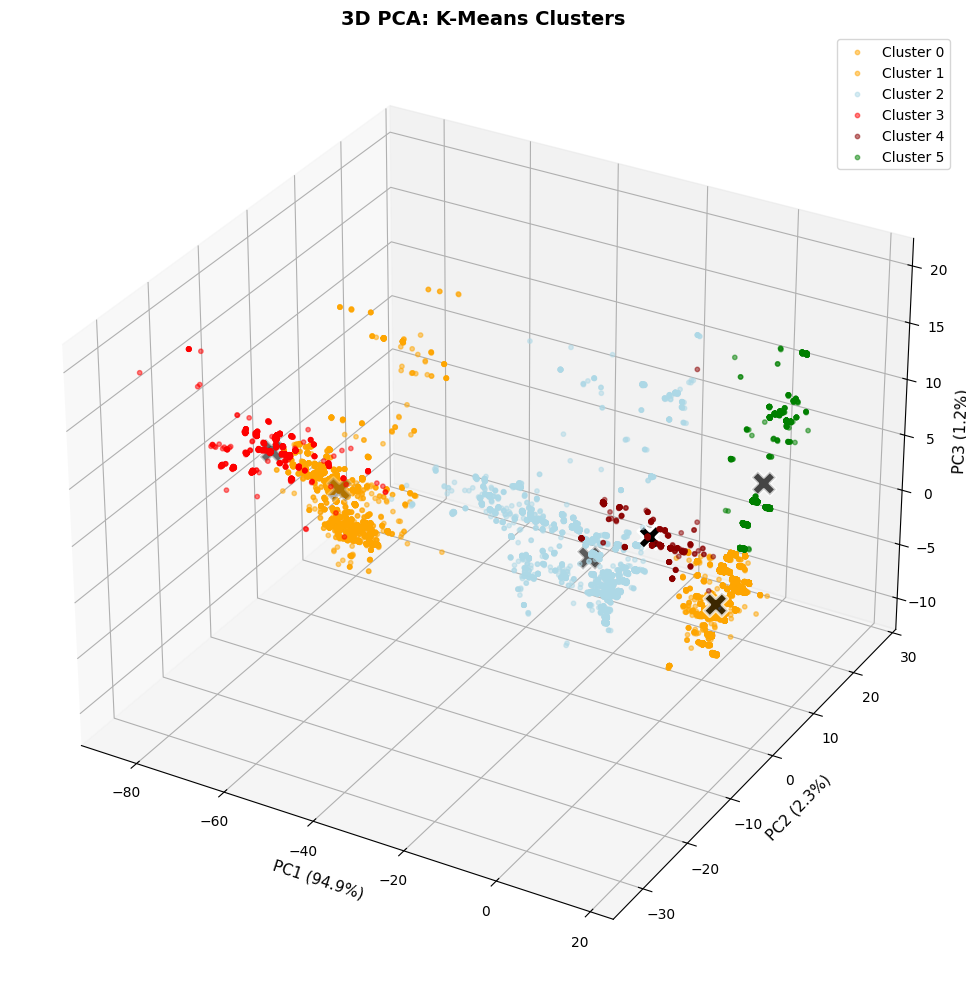

Total variance explained: 98.4%


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled.values)
centroids_pca = pca.transform(kmeans.cluster_centers_)

colors = ['orange', 'orange', 'lightblue', 'red', 'darkred', 'green']

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot clusters
for i, color in enumerate(colors):
    mask = y_pred == i
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], X_pca[mask, 2],
               c=color, label=f'Cluster {i}', alpha=0.5, s=10)

# Plot centroids
ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], centroids_pca[:, 2],
           c='black', marker='X', s=300, edgecolors='white', linewidths=2)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)', fontsize=11)
ax.set_title('3D PCA: K-Means Clusters', fontsize=14, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()

print(f"Total variance explained: {pca.explained_variance_ratio_.sum()*100:.1f}%")

## Comparing Feature Means Across Clusters

### RF feature importance

In [ ]:
y.shape

()

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


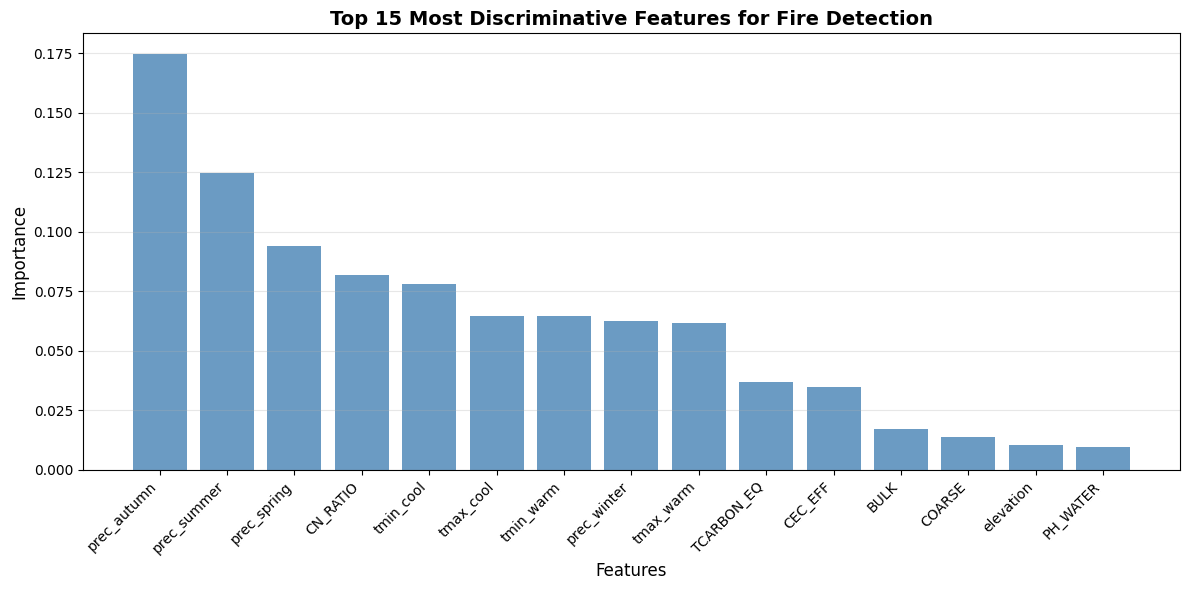

Top 10 Most Discriminative Features:
1. prec_autumn: 0.1746
2. prec_summer: 0.1245
3. prec_spring: 0.0941
4. CN_RATIO: 0.0821
5. tmin_cool: 0.0781
6. tmax_cool: 0.0647
7. tmin_warm: 0.0646
8. prec_winter: 0.0624
9. tmax_warm: 0.0619
10. TCARBON_EQ: 0.0368


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train RF to find which features separate fire/no-fire
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

# Get feature importance
feature_names = X_scaled.columns if hasattr(X_scaled, 'columns') else [f'Feature {i}' for i in range(X_scaled.shape[1])]
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot top 15 features
top_n = 15
top_indices = indices[:top_n]

plt.figure(figsize=(12, 6))
plt.bar(range(top_n), importances[top_indices], color='steelblue', alpha=0.8)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.title('Top 15 Most Discriminative Features for Fire Detection', fontsize=14, fontweight='bold')
plt.xticks(range(top_n), [feature_names[i] for i in top_indices], rotation=45, ha='right')
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Print top features
print("Top 10 Most Discriminative Features:")
for i in range(10):
    idx = indices[i]
    print(f"{i+1}. {feature_names[idx]}: {importances[idx]:.4f}")

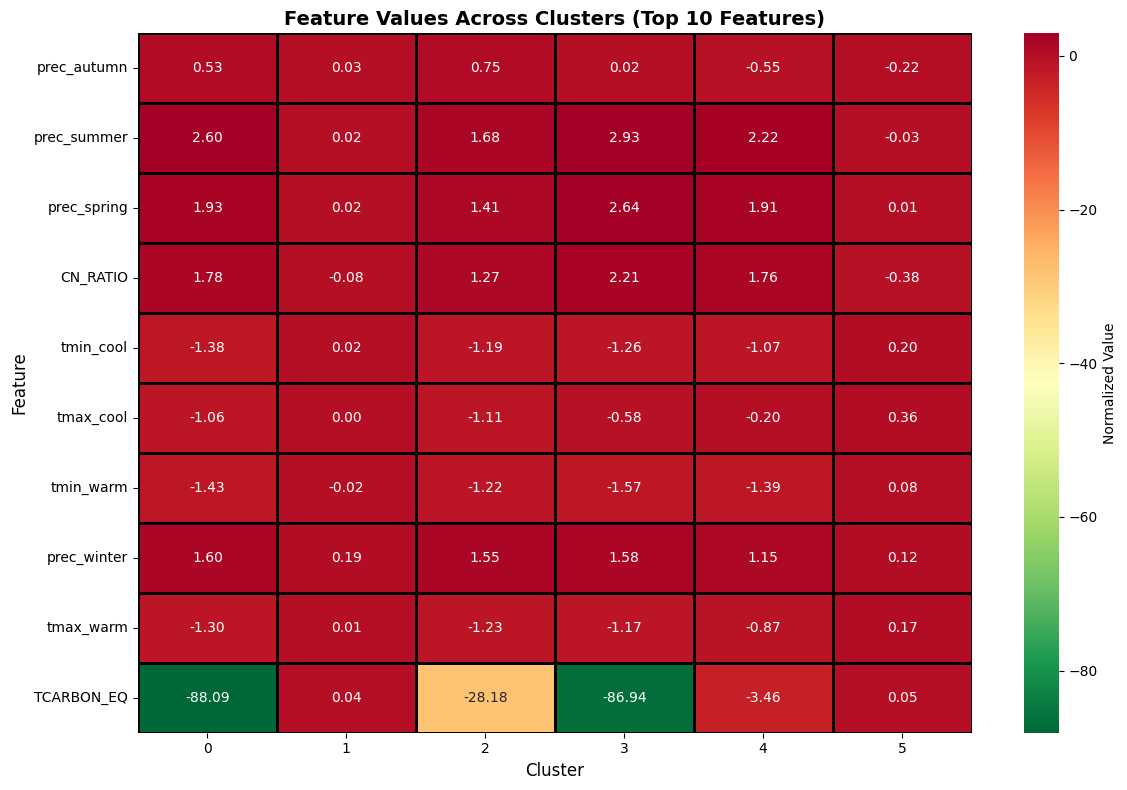

In [ ]:
# Add cluster labels to dataframe
df_analysis = X_scaled.copy()
df_analysis['cluster'] = y_pred
df_analysis['fire'] = y

# Calculate mean feature values per cluster
cluster_means = df_analysis.groupby('cluster').mean()

# Select top discriminative features (from RF)
top_features = [feature_names[i] for i in indices[:10]]

# Heatmap of feature values across clusters
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means[top_features].T, annot=True, fmt='.2f',
            cmap='RdYlGn_r', cbar_kws={'label': 'Normalized Value'},
            linewidths=1, linecolor='black')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Values Across Clusters (Top 10 Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

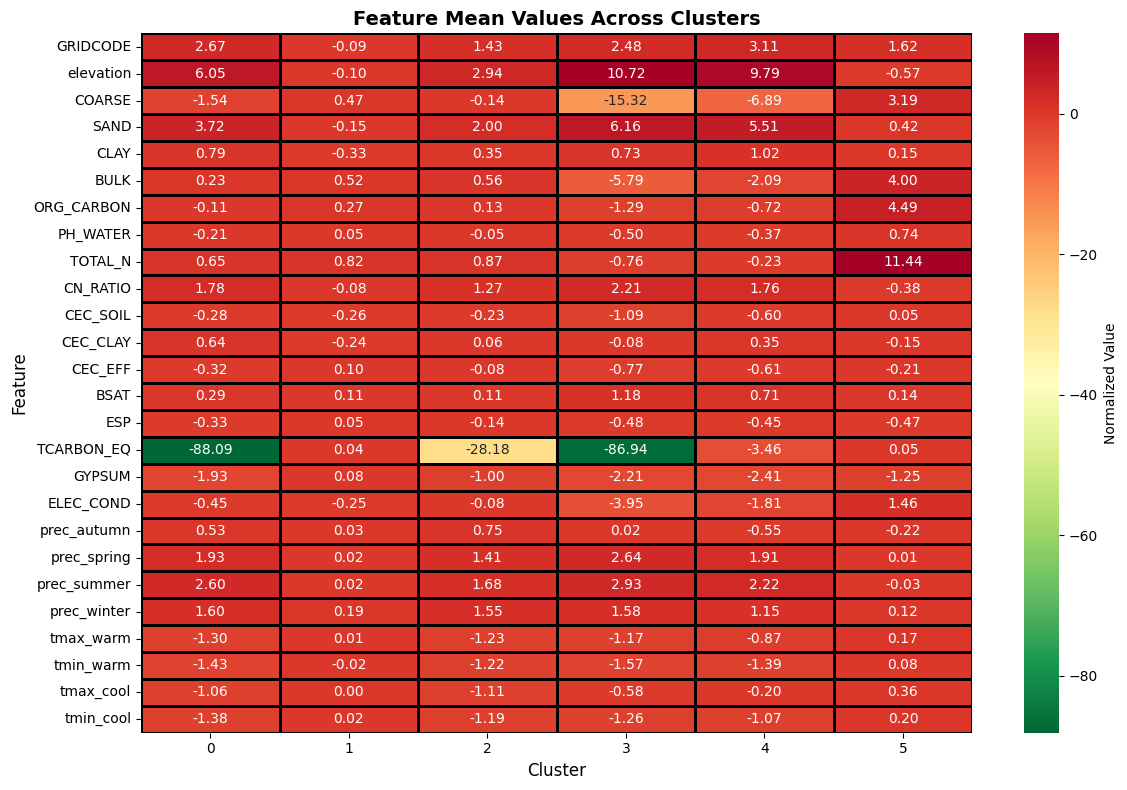

In [21]:
# Add cluster labels to dataframe
df_analysis = X_scaled.copy()
df_analysis['cluster'] = y_pred
df_analysis['fire'] = y

# Calculate mean feature values per cluster
cluster_means = df_analysis.groupby('cluster').mean()

# Select top discriminative features (from RF)
top_features = X_scaled.columns

# Heatmap of feature values across clusters
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means[top_features].T, annot=True, fmt='.2f',
            cmap='RdYlGn_r', cbar_kws={'label': 'Normalized Value'},
            linewidths=1, linecolor='black')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Mean Values Across Clusters', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Kruksal-Wallis Test

In [22]:
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
import pandas as pd

significance_results = []

clusters = sorted(df_analysis['cluster'].unique())

for feature in top_features:
    groups = [
        df_analysis[df_analysis['cluster'] == c][feature].values
        for c in clusters
    ]

    stat, p = kruskal(*groups)
    significance_results.append({
        'feature': feature,
        'H_statistic': stat,
        'p_value': p
    })

sig_df = pd.DataFrame(significance_results)

# Multiple testing correction (Benjamini–Hochberg FDR)
sig_df['p_adj'] = multipletests(sig_df['p_value'], method='fdr_bh')[1]
sig_df['significant'] = sig_df['p_adj'] < 0.05

sig_df.sort_values('p_adj')


,feature,H_statistic,p_value,p_adj,significant
0,GRIDCODE,25407.064802,0.0,0.0,True
1,elevation,15640.170559,0.0,0.0,True
2,COARSE,13499.812175,0.0,0.0,True
3,SAND,21447.610687,0.0,0.0,True
4,CLAY,18970.670762,0.0,0.0,True
5,BULK,10846.157998,0.0,0.0,True
6,ORG_CARBON,13904.206516,0.0,0.0,True
7,PH_WATER,3790.951158,0.0,0.0,True
8,TOTAL_N,12232.916494,0.0,0.0,True
9,CN_RATIO,25888.301985,0.0,0.0,True


## PCA Component Analysis

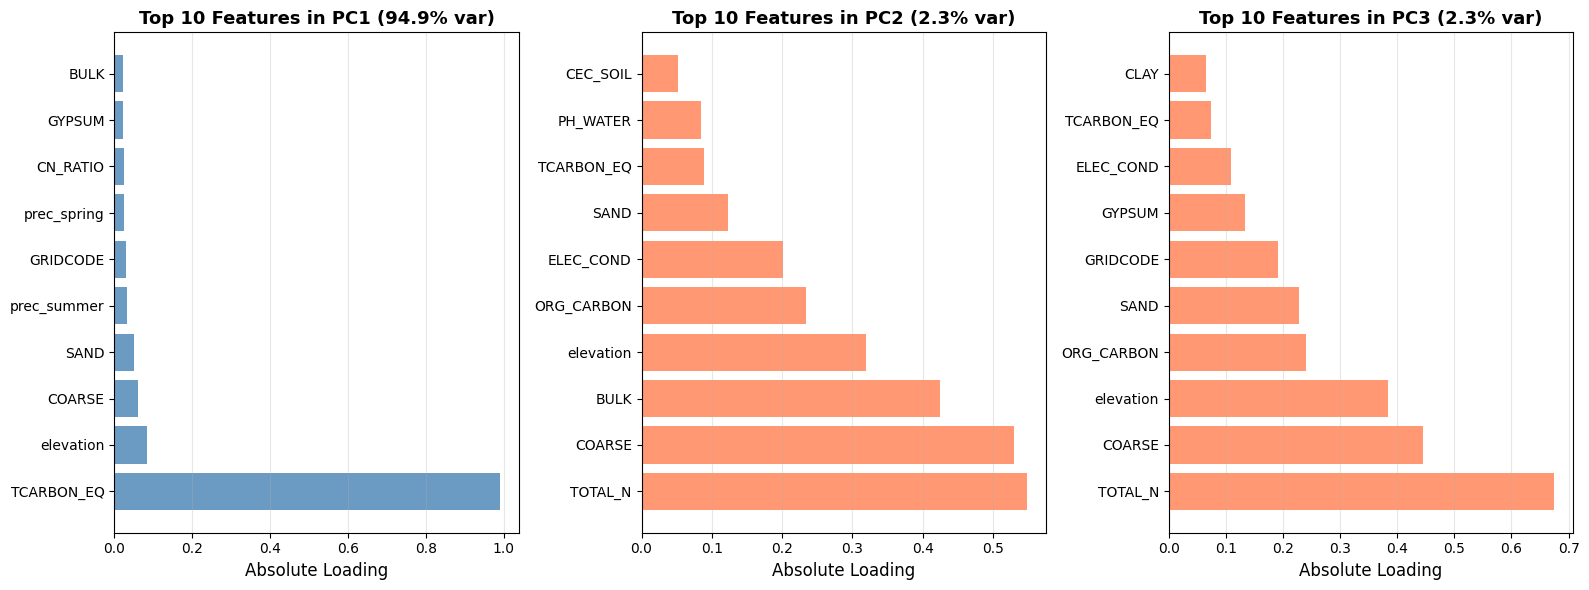

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

pca = PCA(n_components=3)
pca.fit(X_scaled.values)

# Get component loadings
components = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(3)],
    index=feature_names
)

# Plot loadings for PC1 and PC2
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

# PC1 loadings
top_pc1 = components['PC1'].abs().nlargest(10)
ax1.barh(range(len(top_pc1)), top_pc1.values, color='steelblue', alpha=0.8)
ax1.set_yticks(range(len(top_pc1)))
ax1.set_yticklabels(top_pc1.index)
ax1.set_xlabel('Absolute Loading', fontsize=12)
ax1.set_title(f'Top 10 Features in PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)',
              fontsize=13, fontweight='bold')
ax1.grid(alpha=0.3, axis='x')

# PC2 loadings
top_pc2 = components['PC2'].abs().nlargest(10)
ax2.barh(range(len(top_pc2)), top_pc2.values, color='coral', alpha=0.8)
ax2.set_yticks(range(len(top_pc2)))
ax2.set_yticklabels(top_pc2.index)
ax2.set_xlabel('Absolute Loading', fontsize=12)
ax2.set_title(f'Top 10 Features in PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)',
              fontsize=13, fontweight='bold')
ax2.grid(alpha=0.3, axis='x')

# PC3 loadings
top_pc3 = components['PC3'].abs().nlargest(10)
ax3.barh(range(len(top_pc3)), top_pc3.values, color='coral', alpha=0.8)
ax3.set_yticks(range(len(top_pc3)))
ax3.set_yticklabels(top_pc3.index)
ax3.set_xlabel('Absolute Loading', fontsize=12)
ax3.set_title(f'Top 10 Features in PC3 ({pca.explained_variance_ratio_[1]*100:.1f}% var)',
              fontsize=13, fontweight='bold')
ax3.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()